In [1]:
import json
import os
import sys
import importlib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import ttest_1samp, wilcoxon
import statannot

from statsmodels.stats.multitest import fdrcorrection, multipletests

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
class_abbrevs = json.load(open('../data/metadata/molec_class_abbrev.json'))

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

In [3]:
gb = np.power(2, data.loc[:, data_cols])
# gb = gb.drop(['1091_8_FBG', '1091_10_FBG'], axis=1) 
gb = (gb
 .T
 .join(fg[['animal', 'bg_type']])
 .groupby(['animal', 'bg_type'])
)
gb = (gb.std() / gb.mean()) * 100

# change dtype of animal index back to int
idx = gb.index
gb.index = gb.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])

gb = gb.drop(1091, level='animal')

# Sort according to OGTT glucAUC order
sorter = ap.loc[ap['original'], 'Nile rat label'].sort_values().index
gb = gb.reindex(sorter, level='animal')

display(gb)

m_0        m_1        m_2        m_3         m_4  \
animal bg_type                                                            
1093   FBG       53.464270  17.880001  44.250662   8.394440   22.613023   
       RBG       39.026897  11.652806  38.806249  28.857759   51.435289   
1092   FBG       34.177809  14.478312  35.117777  10.121304  101.793867   
       RBG       23.623592  11.054094  12.752727  29.271496  101.279148   
1074   FBG       41.796211  49.819737  40.514368   9.226702  133.628845   
       RBG       49.853000  18.802471  24.756410  33.676962   16.997728   
1062   FBG       42.979048  27.955164  62.624951  30.996139  160.287064   
       RBG       19.083103  24.371803  52.503763  12.482614   23.810329   
1102   FBG       61.058866  14.404511  41.061658  14.555573  114.041335   
       RBG       70.763276  11.945092  78.894882   2.147696  104.513330   
1060   FBG      135.033146  11.724372  38.015422   9.518486  171.980900   
       RBG      109.122505  27.174735  80.128477  13.155240   88.240480   
1101   FBG       35.251797  18.784187  28.128477  17.021727   88.760300   
       RBG       38.021394   6.547001  32.433858  10.397039   68.806258   
1082   FBG       53.819767  13.035534  23.361274  18.722329   88.575586   
       RBG       72.632782  12.717651  21.561572  11.503434   90.954593   
1076   FBG       42.521250  39.558616  75.738414  29.379181  157.000903   
       RBG       92.719056   7.771533  58.085292  19.890841  107.344687   

                      m_5        m_6        m_7        m_8        m_9  ...  \
animal bg_type                                                         ...   
1093   FBG       4.130082   8.411879  11.617008  11.438302  16.488283  ...   
       RBG      13.126940  14.579750   4.443541  15.681928  10.127275  ...   
1092   FBG      13.261534  24.046540  13.658066  27.386919   7.298736  ...   
       RBG      30.385349  28.730235  31.744977  29.720533  24.070132  ...   
1074   FBG       8.430682  15.635192  56.206303  17.458921  32.239555  ...   
       RBG      23.611413  21.558153  10.817154  16.923088   5.885145  ...   
1062   FBG      27.082323  10.321457   7.961478  15.700581  27.218032  ...   
       RBG      22.673909   3.903375  20.813806   6.872019   8.850415  ...   
1102   FBG      10.581403  11.901872  19.190857  17.154349   5.827639  ...   
       RBG      11.838497   3.067916  17.539519   4.276553  13.453786  ...   
1060   FBG      20.668780  16.601535  15.573181  20.589889   8.088724  ...   
       RBG      12.514570  12.742306  25.169451  11.635403   7.380230  ...   
1101   FBG      30.739933  46.565770  35.547258  42.313600  16.411968  ...   
       RBG       8.991498   4.670655  21.596673   4.683508   7.621106  ...   
1082   FBG      18.334695  36.413534  17.034660  35.561428   6.837246  ...   
       RBG      17.183937  18.556488  13.846643  17.162169  23.161192  ...   
1076   FBG      66.918022  43.569026  51.807949  45.716528  46.971014  ...   
       RBG       7.201984   6.275901  14.192407   9.498442   6.511294  ...   

                    l_907      l_908       l_909       l_910       l_911  \
animal bg_type                                                             
1093   FBG      61.684436  82.006414   79.862391   99.452150   63.461796   
       RBG      32.352053  29.839354   36.729683   73.485602   29.681518   
1092   FBG      54.133725  81.647621   37.542374  137.967077   53.064706   
       RBG      23.840652  32.598691   33.298731   89.725561   30.831242   
1074   FBG      54.442843  50.806159   49.873126  114.926248   59.028862   
       RBG      17.060906  18.902980   30.443218   13.545431   16.917963   
1062   FBG      57.768430  40.506285   45.445081   68.452936   49.886002   
       RBG      29.641263  43.362206   46.959111   38.064287   42.031696   
1102   FBG      37.432802   9.501152   26.982010   42.319090   24.371699   
       RBG      36.782721  38.032674   35.697851   60.076389   32.702872   
1060   FBG      53.913007  62.266682   70.789872 

# Create dataframe with groupings of %RSDs
1. Select indexes from `data` for each metabolite group
2. get nonfasted RSDs, fasted RSDs, paired Nonfasted-fasted differences in a matrix
3. calculate pvalues and FDR correct

In [4]:
groups = [
    ('All Features', data.index),
    ('All Lipids', data.loc[data['Type'] == 'lipid'].index),
    ('All Polar Metabolites', data.loc[data['Type'] == 'metabolite'].index),
    ('Identified Lipids', data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')].index),
    ('Identified Polar Metabolites', data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified')].index),
    ('Unidentified Lipids', data.loc[(data['Type'] == 'lipid') & (data['ID'] == 'Unidentified')].index),
    ('Unidentified Polar Metabolites', data.loc[(data['Type'] == 'metabolite') & (data['ID'] == 'Unidentified')].index),
]

groups += [(mc, data.loc[data['molec_class'] == mc].index) for mc in data['molec_class'].unique()]
groups += [(lsc, data.loc[data['superclass'] == lsc].index) for lsc in src.plots.lipid_categories]
groups = {x[0]: x[1] for x in groups}

for name, idx in groups.items():
    df = gb.loc[:, idx]
#     df = df.drop('1091', level='animal')
    # in order for data to be truly paired, you must find RSD difference within each animal first
    nonfasted_rsd = df.xs('RBG', level='bg_type')
    fasted_rsd = df.xs('FBG', level='bg_type')
    df = nonfasted_rsd - fasted_rsd
    indexes = df.columns
    # The next choice is whether to use median or mean 
    #     or not perform any averaging at all and instead unravel all rsd diffs from all Nile rats. 
    # Mean
    meandf = df.mean().values
    
    # Median
    mediandf = df.median().values
    
    # ravel (no averaging across Nile rats)
    raveldf = df.values.ravel()
    
    groups[name] = {'indexes': indexes, 
                    'rsd_diff_mean_across_rats':   meandf, 
                    'rsd_diff_median_across_rats': mediandf, 
                    'rsd_diff_no_agg_across_rats': raveldf, 
                    'pval_mean':   wilcoxon(meandf).pvalue, 
                    'pval_median': wilcoxon(mediandf).pvalue,
                    'pval_no_agg': wilcoxon(raveldf).pvalue,
                    'nonfasted_rsd': nonfasted_rsd, 
                    'fasted_rsd': fasted_rsd}
groups = pd.DataFrame(groups).T
for pval in ['pval_mean', 'pval_median', 'pval_no_agg']:
    groups['q' + pval[1:]] = fdrcorrection(groups[pval])[1]
groups

,indexes,rsd_diff_mean_across_rats,rsd_diff_median_across_rats,rsd_diff_no_agg_across_rats,pval_mean,pval_median,pval_no_agg,nonfasted_rsd,fasted_rsd,qval_mean,qval_median,qval_no_agg
All Features,"Index(['m_0', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5...","[1.6381599759208854, -8.400361084041759, 1.234...","[2.7695971575408933, -3.5833610551347093, -5.4...","[-14.437373012978284, -6.227194885417942, -5.4...",0.0,0.0,0.0,i m_0 m_1 m_2 ...,i m_0 m_1 m_2 ...,0.0,0.0,0.0
All Lipids,"Index(['l_0', 'l_1', 'l_2', 'l_3', 'l_4', 'l_5...","[-2.3403984164498515, 0.6689573591389089, -12....","[-0.688513551963986, 4.089245531675367, -6.614...","[34.436097368381496, -16.235634463825853, 0.08...",0.0,0.0,0.0,i l_0 l_1 l_2 ...,i l_0 l_1 l_2 ...,0.0,0.0,0.0
All Polar Metabolites,"Index(['m_0', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5...","[1.6381599759208854, -8.400361084041759, 1.234...","[2.7695971575408933, -3.5833610551347093, -5.4...","[-14.437373012978284, -6.227194885417942, -5.4...",0.0,0.042726,0.0,i m_0 m_1 m_2 ...,i m_0 m_1 m_2 ...,0.0,0.090794,0.0
Identified Lipids,"Index(['l_0', 'l_1', 'l_2', 'l_3', 'l_4', 'l_5...","[-2.3403984164498515, 0.6689573591389089, -12....","[-0.688513551963986, 4.089245531675367, -6.614...","[34.436097368381496, -16.235634463825853, 0.08...",0.0,0.0,0.0,i l_0 l_1 l_2 ...,i l_0 l_1 l_2 ...,0.0,0.0,0.0
Identified Polar Metabolites,"Index(['m_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7...","[1.2344697543642367, 1.4941331322213989, -42.8...","[-5.444412835873038, -6.6246873350554125, -19....","[-5.444412835873038, 20.46331867651901, 28.822...",0.000002,0.014537,0.000061,i m_2 m_3 m_4 ...,i m_2 m_3 m_4 ...,0.000009,0.03802,0.000148
Unidentified Lipids,"Index(['l_11', 'l_12', 'l_13', 'l_14', 'l_15',...","[-1.2444449064747063, -7.720642191440841, -3.2...","[-20.720604118223463, -8.380712235224742, -0.7...","[40.66123355419159, -8.380712235224742, -6.120...",0.000002,0.000045,0.0,i l_11 l_12 l_13 ...,i l_11 l_12 l_13 ...,0.000009,0.000217,0.0
Unidentified Polar Metabolites,"Index(['m_0', 'm_1', 'm_10', 'm_12', 'm_14', '...","[1.6381599759208854, -8.400361084041759, 1.127...","[2.7695971575408933, -3.5833610551347093, 5.67...","[-14.437373012978284, -6.227194885417942, 14.5...",0.0,0.253206,0.0,i m_0 m_1 m_10 ...,i m_0 m_1 m_10 ...,0.0,0.391319,0.0
Unidentified,"Index(['m_0', 'm_1', 'm_10', 'm_12', 'm_14', '...","[1.6381599759208854, -8.400361084041759, 1.127...","[2.7695971575408933, -3.5833610551347093, 5.67...","[-14.437373012978284, -6.227194885417942, 14.5...",0.0,0.000089,0.0,i m_0 m_1 m_10 ...,i m_0 m_1 m_10 ...,0.0,0.000379,0.0
Nitrogen heterocycle,"Index(['m_2', 'm_3', 'm_4', 'm_21', 'm_32', 'm...","[1.2344697543642367, 1.4941331322213989, -42.8...","[-5.444412835873038, -6.6246873350554125, -19....","[-5.444412835873038, 20.46331867651901, 28.822...",0.067383,0.024414,0.013868,i m_2 m_3 m_4 ...,i m_2 m_3 m_4 ...,0.095459,0.055339,0.022454
Amino acid,"Index(['m_5', 'm_6', 'm_9', 'm_17', 'm_22', 'm...","[-5.846595204925829, -11.042447203351603, -6.7...","[-1.1507578321231726, -6.418081815150253, -6.3...","[8.996858073009857, 6.167871237053841, -6.3610...",0.000122,0.625732,0.073329,i m_5 m_6 m_9 ...,i m_5 m_6 m_9 ...,0.000346,0.747643,0.103883


# Create a side-by-side plot on 4 groups: 
1. All features
2. All ID metabolites
2. All ID Lipids

2. All TGs
3. All Phospholipids 
## Left: Horizontal-oriented violin plots, paired, fasted and non-fasted, 
## Right: RSD percentage point difference distribution with n=X and number lower in non-fasted or fasted

In [7]:
def nearest_bin(x, binwidth=2):
    return int(binwidth * round(x / binwidth))

def plot_rsd_diff_hist(df, ax, binwidth=2, color_adjust_amount=1):
    bins = list(range(nearest_bin(df.min(), binwidth), nearest_bin(df.max(), binwidth), binwidth))
    _, _, histbars = ax.hist(df, bins=bins, lw=0)
    _, _, hist2bars = ax.hist(df, bins=bins, zorder=-10)
    for i, (bar, bar2) in enumerate(zip(histbars, hist2bars)):
        if bar.get_x() < 0:
            c = src.plots.adjust_color(colors['Fed'], color_adjust_amount)
            bar.set(fc=c)
            bar2.set(ec=src.plots.adjust_color(c, 1.5), lw=1.5)
        else:
            c = src.plots.adjust_color(colors['Fasted'], color_adjust_amount)
            bar.set(fc=c, zorder=-5)
            bar2.set(ec=src.plots.adjust_color(c, 1.5), lw=1.5)

Text(0, 0.5, 'Metabolite group')

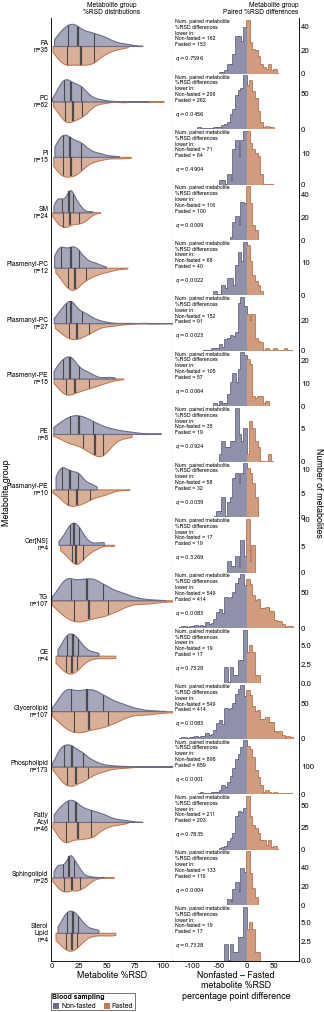

In [8]:
# to_plot_list = ['All Features', 'Identified Polar Metabolites', 'Identified Lipids', 'Glycerolipid', 'Phospholipid']
# group_names  = ['All features', 'Identified\nPolar\nMetabolites', 'Identified\nLipids', 'Glycerolipids', 'Phospholipids']
# custom_yticks = [[0, 100], [0, 6], [0, 30], [0, 6], [0, 20]]
to_plot_list = groups.index[17:]
nrows = len(to_plot_list)

fig, axs = plt.subplots(
    figsize=(4, 2+0.8*nrows), dpi=80, nrows=nrows, ncols=2, gridspec_kw=dict(width_ratios=[1, 1.02], wspace=0, hspace=0),
    sharex='col', facecolor='white', sharey=False)

# to_plot_list = ['All Features', 'Identified Polar Metabolites', 'Identified Lipids', 'Glycerolipid', 'Phospholipid']
# group_names  = ['All features', 'Identified\nPolar\nMetabolites', 'Identified\nLipids', 'Glycerolipids', 'Phospholipids']
# custom_yticks = [[0, 100], [0, 6], [0, 30], [0, 6], [0, 20]]
for i, ((ax, axb), group) in enumerate(zip(axs, to_plot_list)):
    g = groups.loc[group]
    
    # TWO OPTIONS:
    #   1. Ravel to use every paired measurement with no averaging across Nile rats
    nf_values = list(g['nonfasted_rsd'].values.ravel())
    f_values = list(g['fasted_rsd'].values.ravel())
    rsd_diff = g['rsd_diff_no_agg_across_rats']
    qval = g['qval_no_agg']

    #   2. Average across Nile rats
#     nf_values = list(g['nonfasted_rsd'].mean())
#     f_values = list(g['fasted_rsd'].mean())
#     rsd_diff = g['rsd_diff_mean_across_rats']
    qval = g['qval_mean']
    if qval < 1e-4:
        qval = '< 0.0001'
    else:
        qval = f'= {round(qval, 4)}'
    vpdf = pd.DataFrame(nf_values + f_values, columns=['%rsd'])
    vpdf['bg_type'] = len(nf_values) * ['Non-fasted'] + len(f_values) * ['Fasted']
    vpdf['dummy'] = 0
    vp = sns.violinplot(
        data=vpdf, x='%rsd', y='dummy', hue='bg_type', ax=ax, 
        orient='horizontal', inner='quartile', split=True, palette=colors, saturation=1, linewidth=0, cut=0)
    src.plots.adjust_violin_quartiles(ax)
    short_group_name = '\n'.join(group.split(' '))
    ax.set_ylabel(f'{short_group_name}\nn={len(g["indexes"])}', rotation=0, fontsize=6, ha='right', va='center')
    ax.set(xlabel=None, yticks=[])
    
    # Play with inner fill 
    color_adjust_amount = 0.6
    violin_areas = [x for x in ax.get_children() if isinstance(x, plt.matplotlib.collections.PolyCollection)]
    for i, violin_area in enumerate(violin_areas):
        if i % 2 == 0:
            c = colors['Fed']
            light_c = src.plots.adjust_color(c, color_adjust_amount)
        else: 
            c = colors['Fasted']
            light_c = src.plots.adjust_color(c, color_adjust_amount)
        violin_area.set(lw=1, fc=light_c, ec=c, alpha=1, zorder=(1.2 if i % 2 == 0 else 1.1))
    
    num_nonfasted_lower = len(np.where(rsd_diff < 0)[0])
    num_nonfasted_higher = len(np.where(rsd_diff > 0)[0])
    plot_rsd_diff_hist(df=rsd_diff, ax=axb, binwidth=5, color_adjust_amount=0.75, )
    axb.text(
        0.015, 0.19, 
        f'Num. paired metabolite\n%RSD differences\nlower in:\n'
        f'Non-fasted = {num_nonfasted_lower}\nFasted = {num_nonfasted_higher}'
        f'\n\n$q {qval}$', 
        fontsize=4.7, va='bottom', ha='left', transform=axb.transAxes, )
    ax.axvline(109.9, color='0.3', lw=1)
    ax. tick_params(length=0, pad=2, labelsize=7)
    axb.tick_params(length=0, pad=2, labelsize=7)
    ax.legend().remove()
    sns.despine(ax=ax, bottom=False)#(False if i == len(to_plot_list)-1 else True))
    sns.despine(ax=axb, left=True, right=False, top=True, bottom=False)#False if i == len(to_plot_list)-1 else True))

axbl = axs[-1][0]
axbr = axs[-1][1]
axbl.set_xlim(-1, 110)
axbl.set_xlabel('Metabolite %RSD')
axbl.xaxis.set_major_locator(plt.MultipleLocator(25))
axbr.set_xlabel('Nonfasted – Fasted\nmetabolite %RSD\npercentage point difference')
axbr.xaxis.set_major_locator(plt.MultipleLocator(50))
axs[0][0].set_title('Metabolite group\n%RSD distributions', fontsize=6)
axs[0][1].set_title('Metabolite group\nPaired %RSD differences', fontsize=6, loc='right')
# axs[0][1].text(0.01, 1.01, 'Metabolites with\nlower %RSD in\nNon-fasted', fontsize=5, ha='left', va='bottom', transform=axs[0][1].transAxes)
src.plots.custom_legend(
    entries=['Non-fasted', 'Fasted'], ax=axbl, loc=(0, -0.9),
    sort=False, title='Blood sampling', fontsize=6.3, title_fontsize=6.3, ms=6,
    mew=0, marker='s', ncol=2,
    show_frame=True, frame_color='1', frame_edgecolor='0.05', frame_edgewidth=0.5, columnspacing=1,
    handlelength=1.1, handletextpad=0.2)
fig.text(0.975, 0.5, 'Number of metabolites', fontsize=8, ha='right', rotation=270, va='center')
fig.text(0, 0.5, 'Metabolite group', fontsize=8, ha='right', rotation=90, va='center')
# plt.savefig('../reports/figures/Figure3/RSDs_all_metab_groups_supp_col2.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('../reports/figures/Figure3/RSDs_all_metab_groups_supp_col2.png', bbox_inches='tight', dpi=600)

## Plot violins within-Nile rat

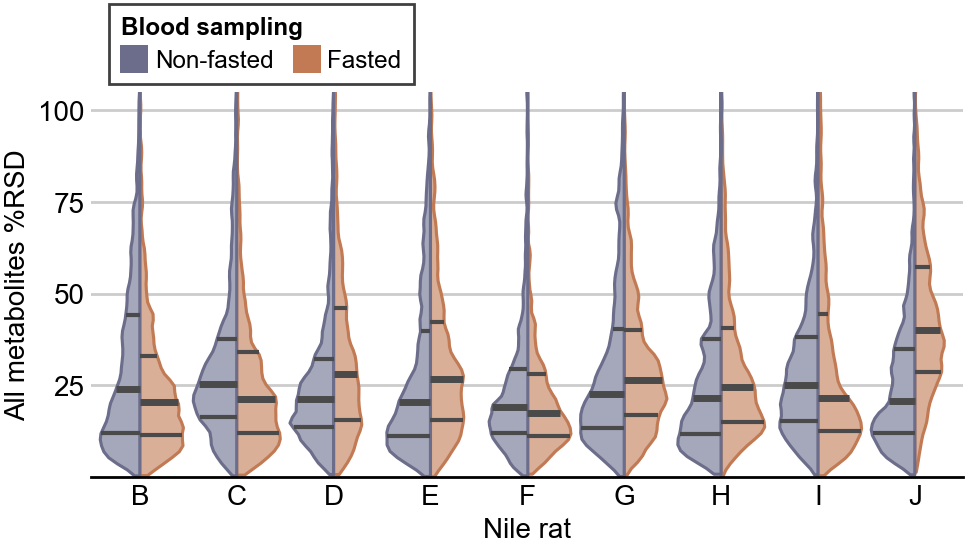

In [9]:
importlib.reload(src.plots)

vpdf = gb.T.melt()
vpdf['Nile rat'] = vpdf['animal'].map(ap['Nile rat label'])

fig, ax = plt.subplots(figsize=(4.5, 2), dpi=250)

sns.violinplot(
    data=vpdf, x='Nile rat', y='value', hue='bg_type', hue_order=['RBG', 'FBG'], palette=colors, 
    dodge=True, ax=ax, linewidth=0,
    inner='quartile', split=True, saturation=1, bw=0.08, cut=0, width=0.9)

# Play with inner fill 
violin_areas = [x for x in ax.get_children() if isinstance(x, plt.matplotlib.collections.PolyCollection)]
for i, violin_area in enumerate(violin_areas):
    if i % 2 == 0:
        c = colors['Fed']
        light_c = src.plots.adjust_color(c, color_adjust_amount)
    else: 
        c = colors['Fasted']
        light_c = src.plots.adjust_color(c, color_adjust_amount)
    violin_area.set(lw=0.9, fc=light_c, ec=c, alpha=1, zorder=(1.2 if i % 2 == 0 else 1.1))

# Adjust inner quartiles linewidths:
src.plots.adjust_violin_quartiles(ax, lw=1.2, median_lw=2)

ax.set(ylim=(0.01, 105), ylabel='All metabolites %RSD')
ax.tick_params(length=0, pad=2, labelsize=8)
ax.yaxis.set_major_locator(plt.MultipleLocator(25))
# ax.set_yticks([25, 50, 75, 100])

ax.legend().remove()
src.plots.custom_legend(
    ax=ax, entries=['Non-fasted', 'Fasted'], sort=False, loc=(0.02, 1.02),
    title='Blood sampling', fontsize=7, title_fontsize=7, mew=0, marker='s', 
    show_frame=True, borderpad=0.5,
    ncol=2, columnspacing=0.8,)
ax.grid(axis='y', lw=0.8, color='0.8')
sns.despine(left=True)
# plt.savefig('../reports/figures/Figure3/RSDs_Nile_rats_v3.pdf', bbox_inches='tight', dpi=300)

## Calculated within-Nile rat paired nonfasted - fasted percentage point differences and calculate p-value

## Conclusion: After paired Wilcoxon test and BH fdr correction, 7 out of 9 are significant
## 4 are signif lower in non-fasted (D, E, H, J)
## 3 are signif lower in fasted (B, C, F) 

In [51]:
ratpair = gb.groupby('animal').diff().xs('RBG', level='bg_type')

results = {}
for i, row in ratpair.iterrows():
    label = ap.loc[i, 'Nile rat label']
    percent_nf_lower = len(row.loc[row < 0]) / len(row) * 100 
    nf_lower = percent_nf_lower > 50
    pval = wilcoxon(row).pvalue
    results[label] = {'%lower': percent_nf_lower, 'is_nf_lower': nf_lower, 'is_f_lower': (not nf_lower), 'pval': pval}

results = pd.DataFrame(results).T
results['qval'] = fdrcorrection(results['pval'])[1]
results['qval_signif'] = results['qval'] < 0.05
results['nf_signif_lower'] = results['qval_signif'] & results['is_nf_lower']
results['f_signif_lower'] = ((results['qval_signif']) & (results['is_f_lower']))
results

,%lower,is_nf_lower,is_f_lower,pval,qval,qval_signif,nf_signif_lower,f_signif_lower
B,41.802697,False,True,0.0,0.0,True,False,True
C,37.260468,False,True,0.0,0.0,True,False,True
D,59.971611,True,False,0.0,0.0,True,True,False
E,60.468417,True,False,0.0,0.0,True,True,False
F,46.132009,False,True,0.02337,0.030047,True,False,True
G,52.377573,True,False,0.094432,0.106236,False,False,False
H,60.184528,True,False,0.0,0.0,True,True,False
I,48.970901,False,True,0.306238,0.306238,False,False,False
J,79.418027,True,False,0.0,0.0,True,True,False


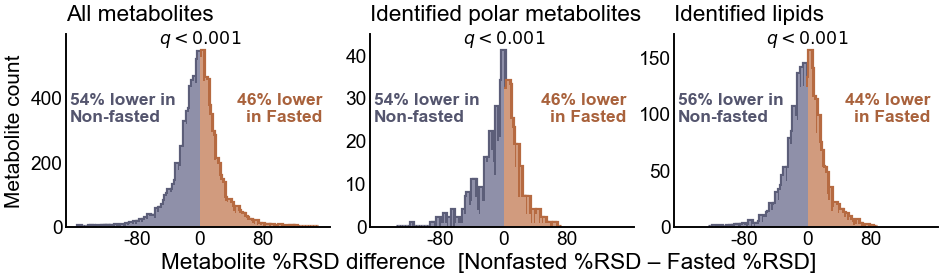

In [777]:
fig, axs = plt.subplots(
    figsize=(4.5, 1), dpi=250, nrows=1, ncols=3, gridspec_kw=dict(width_ratios=[1, 1, 1], wspace=0.15),
    sharex=True, facecolor='white', sharey=False)

to_plot_list = ['All Features', 'Identified Polar Metabolites', 'Identified Lipids']
group_names  = ['All metabolites', 'Identified polar metabolites', 'Identified lipids']
custom_binwidths = [2, 2, 2]
for i, (axb, group, group_name, custom_binwidth) in enumerate(zip(axs, to_plot_list, group_names, custom_binwidths)):
    g = groups.loc[group]
    
    # TWO OPTIONS:
    #   1. Ravel to use every paired measurement with no averaging across Nile rats
    nf_values = list(g['nonfasted_rsd'].values.ravel())
    f_values = list(g['fasted_rsd'].values.ravel())
    rsd_diff = g['rsd_diff_no_agg_across_rats']
    qval = g['qval_no_agg']

    #   2. Average across Nile rats
        #     nf_values = list(g['nonfasted_rsd'].mean())
        #     f_values = list(g['fasted_rsd'].mean())
        #     rsd_diff = g['rsd_diff_mean_across_rats']
        #     qval = g['qval_mean']
    if qval < 1e-3:
        qval = '< 0.001'
    else:
        qval = f'= {round(qval, 5)}'
    
    num_nonfasted_lower = len(np.where(rsd_diff < 0)[0])
    num_nonfasted_higher = len(np.where(rsd_diff > 0)[0])
    percent_nf_lower  = str(round(num_nonfasted_lower /len(rsd_diff), 2))[2:]
    percent_nf_higher = str(round(num_nonfasted_higher/len(rsd_diff), 2))[2:]
    plot_rsd_diff_hist(df=rsd_diff, ax=axb, color_adjust_amount=0.75, binwidth=custom_binwidth)
    
    trans = plt.matplotlib.transforms.blended_transform_factory(axb.transData, axb.transAxes)
    
    axb.text(0, 1.03, f'$q {qval}$', va='top', ha='center', fontsize=5, transform=trans)
    axb.text(0.015, 0.7, f'{percent_nf_lower}% lower in\nNon-fasted', va='top', ha='left', 
             transform=axb.transAxes, fontsize=5, fontweight='bold', c=src.plots.adjust_color(colors['Fed'], 1.2))
    axb.text(0.97, 0.7, f'{percent_nf_higher}% lower\nin Fasted', va='top', ha='right', 
             transform=axb.transAxes, fontsize=5, fontweight='bold', c=src.plots.adjust_color(colors['Fasted'], 1.2))
    axb.set_ylim(top=axb.get_ylim()[1] * 1.04)
    axb.set_title(group_name, loc='left', fontsize=6.5)
    axb.tick_params(length=0, pad=1, labelsize=5.5)
#     axb.xaxis.set_major_locator(plt.MultipleLocator(80))
    axb.set_xticks([-80, 0, 80])
    axb.spines[:].set_lw(0.55)
    
axs[0].text(-0.16, 0.5, 'Metabolite count', fontsize=6, 
            ha='right', va='center', rotation=90, transform=axs[0].transAxes)
fig.supxlabel('Metabolite %RSD difference  [Nonfasted %RSD – Fasted %RSD]', fontsize=6.5, va='top')
sns.despine()

plt.savefig('../reports/figures/Figure3/RSDs_metab_group_v3.pdf', bbox_inches='tight', dpi=300)

# Calculate significance of difference between fasted and fed for each metabolite 
- wilcoxon 1 sample test with n=9 paired samples, on all 1400 total features, BH FDR corrected

## Conclusion: only 90 metabolites have a signif RSD difference, but after BH FDR correction, 0 have signif diff

In [53]:
results = {}
for colname, col in gb.iteritems():
    rsd_diff = col.xs('RBG', level='bg_type') - col.xs('FBG', level='bg_type')
    results[colname] = wilcoxon(rsd_diff).pvalue
results = pd.Series(results)
display(results)
display((results < 0.05).sum())
display(fdrcorrection(results)[0].sum())

m_0      0.910156
m_1      0.074219
m_2      0.734375
m_3      0.820312
m_4      0.074219
           ...   
l_912    0.203125
l_913    0.003906
l_914    0.300781
l_915    0.250000
l_916    0.570312
Length: 1409, dtype: float64

90

0